In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
!pip install albumentations --upgrade
import albumentations
import numpy as np
from IPython.display import clear_output

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

import sys
sys.path.append('/content/gdrive/MyDrive/PyTorch/')
from MiniTorch.minitorch import colab_utils
colab_utils.copy_minitorch_to_local()
sys.path.append("/content/")
import datasets
from minitorch import MiniTorch
%load_ext autoreload
%autoreload 2

clear_output()

# Prepare Data

In [67]:
# colab_utils.update_package('minitorch.py')
# colab_utils.update_package('metrics.py')

In [3]:
# Download data
torchvision.datasets.MNIST('/content/images/', train=True, download=True)
torchvision.datasets.MNIST('/images/', train=False, download=True)

# Read in data
X_train, y_train = torch.load('/content/images/MNIST/processed/training.pt')
X_test, y_test = torch.load('/content/images/MNIST/processed/test.pt')

# Combine data
X = np.vstack([X_train.numpy(), X_test.numpy()])
y = np.hstack([y_train.numpy(), y_test.numpy()]).astype(str)

clear_output()

# Load Data

In [4]:
tfm = albumentations.Compose([
  albumentations.Normalize(mean=[0.1307], std=[0.3081], p=1.)
], p=1.)
tfms = {
    'train':tfm,
    'validation':tfm,
    'test':tfm,
    'inference':tfm
}

# TODO: Implement different train/test/split schemes (k-fold cv)
minitorch = MiniTorch(X, y, 
                      datasets.MatrixDataset,
                      transforms=tfms,
                      val_size=0.10, test_size=0.10,
                      batch_sizes=(64,-1,-1), num_workers=(0,0,0))

Data is split:
Training shape: ((55999, 28, 28), (55999, 10))
Validation shape: ((7000, 28, 28), (7000, 10))
Testing shape: ((7001, 28, 28), (7001, 10))

Data is loaded into DataLoaders.


# Train New Model

In [5]:
# Using the model architecture found here: https://nextjournal.com/gkoehler/pytorch-mnist

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
minitorch.load_net(net=Net(), weights='equal',
                   chosen_criterion=nn.CrossEntropyLoss, 
                   chosen_optimizer=optim.SGD,
                   chosen_optimizer_params={'lr':0.01, 'momentum':0.5})


Network is loaded.



[1,   150] train_loss: 2.144 | val_loss: 1.483
[1,   300] train_loss: 1.223 | val_loss: 0.571
[1,   450] train_loss: 0.825 | val_loss: 0.401
[1,   600] train_loss: 0.697 | val_loss: 0.337
[1,   750] train_loss: 0.597 | val_loss: 0.292
[2,   150] train_loss: 0.936 | val_loss: 0.211
[2,   300] train_loss: 0.469 | val_loss: 0.204
[2,   450] train_loss: 0.420 | val_loss: 0.180
[2,   600] train_loss: 0.416 | val_loss: 0.167
[2,   750] train_loss: 0.374 | val_loss: 0.157


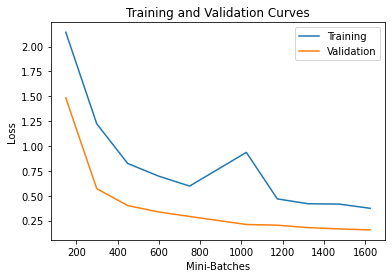

Finished Training


In [7]:
minitorch.train(epochs=2, log_mini_batches=150)

# Load Trained Model (optional)

Loaded epoch2_model.pt in eval mode.



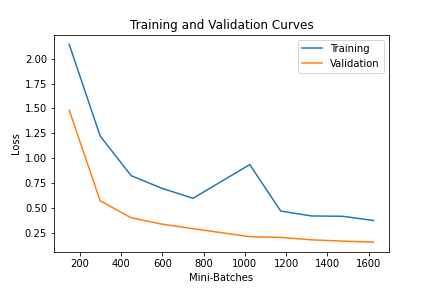

In [65]:
minitorch = MiniTorch.load_checkpoint(net=Net(), 
                                      checkpoints_path='/content/model_checkpoints/20201220T033109_models/',
                                      model_name='epoch2_model.pt', load_type='eval')

# Evaluate

Evaluating Train set...
100%|██████████| 875/875 [00:14<00:00, 60.66it/s]
Train Accuracy: 95.93%
Train Hit@N: 0.06211

Evaluating Validation set...
100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
Validation Accuracy: 95.51%
Validation Hit@N: 0.07014

Evaluating Test set...
100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
Test Accuracy: 95.29%
Test Hit@N: 0.07627



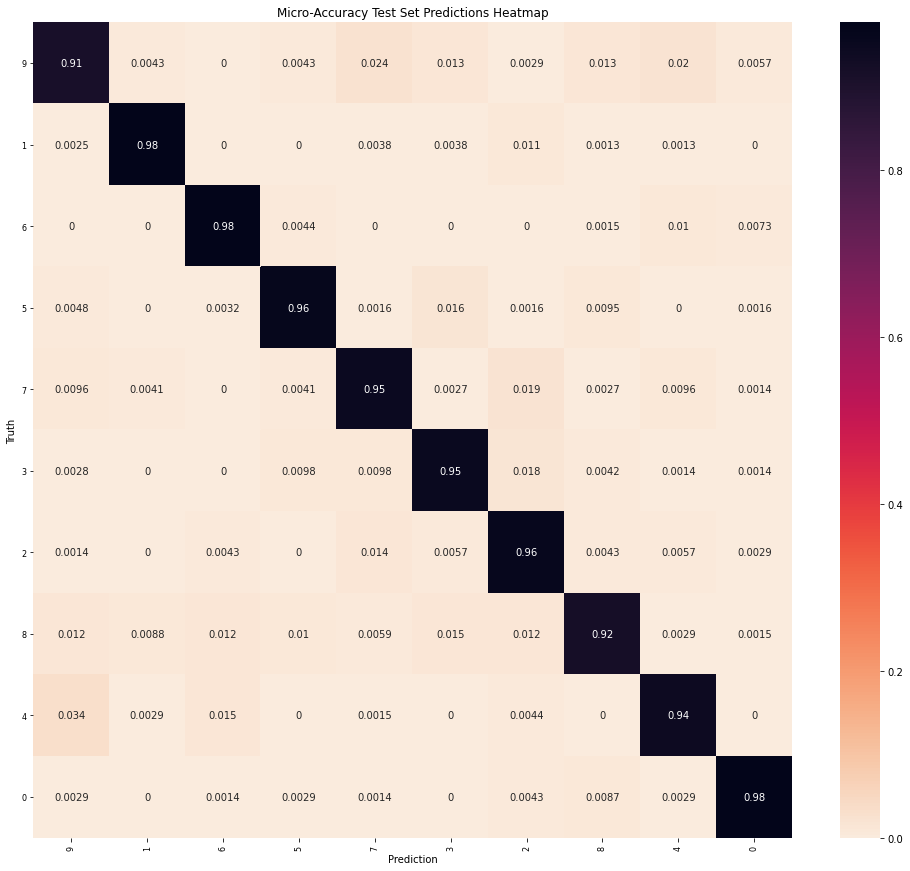

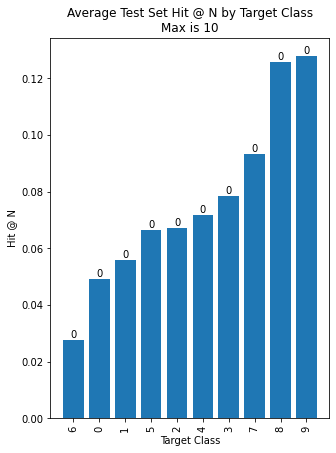

In [66]:
# TODO: refactor evaluation process
minitorch.evaluate(evaluation_metrics=['accuracy', 'hit@n'])